In [29]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import pickle
from tqdm import tqdm
from utils import (
    generate_sparse,
    generate_sparse_randn,
    sign,
    snr,
    angular_error,
    hard_threshold,
)
from algos import reconstruct, reconstruct_1bit, reconstruct_biht

## Preliminaries

Set random seed.

In [2]:
np.random.seed(0)

## Visualizing reconstructions

In [3]:
# Parameters
n = 1000
s = 10
m = 500

x_0 = generate_sparse_randn(n, s)

# Generate sensing matrix
A = np.random.randn(m, n)
# Observe y
y = sign(A.dot(x_0))

In [4]:
xx_biht = reconstruct_biht(y, A, s, 100, 1e-2)

In [5]:
xx = reconstruct_1bit(y, A)

In [6]:
xx_cs = reconstruct(y, A)

To be fair, we give the `cs` method access to `s` by thresholding, since `biht` has access to it.

In [7]:
xx_cs_threshold = hard_threshold(xx_cs, s)

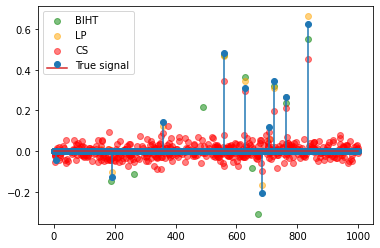

In [8]:
plt.stem(np.arange(n), x_0 / np.linalg.norm(x_0), label="True signal")
plt.scatter(np.arange(n), xx_biht / np.linalg.norm(xx_biht), label="BIHT", alpha=0.5, color="green")
plt.scatter(np.arange(n), xx / np.linalg.norm(xx), label="LP", alpha=0.5, color="orange")
plt.scatter(np.arange(n), xx_cs / np.linalg.norm(xx_cs), label="CS", alpha=0.5, color="red")

plt.legend()
plt.savefig(f"figures/recon-synth-{m}.png", dpi=800)
plt.show()

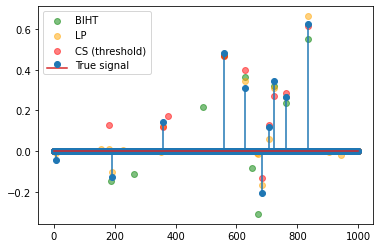

In [9]:
plt.stem(np.arange(n), x_0 / np.linalg.norm(x_0), label="True signal")
plt.scatter(np.arange(n), xx_biht / np.linalg.norm(xx_biht), label="BIHT", alpha=0.5, color="green")
plt.scatter(np.arange(n), xx / np.linalg.norm(xx), label="LP", alpha=0.5, color="orange")
plt.scatter(np.arange(n), xx_cs_threshold / np.linalg.norm( xx_cs_threshold), label="CS (threshold)", alpha=0.5, color="red")

plt.legend()
plt.savefig(f"figures/recon-synth-{m}-thresh.png", dpi=800)
plt.show()

In [10]:
snr_1bit = snr(xx / np.linalg.norm(xx), x_0 / np.linalg.norm(x_0))
snr_cs = snr(xx_cs / np.linalg.norm(xx_cs_threshold), x_0 / np.linalg.norm(x_0))
snr_biht = snr(xx_biht / np.linalg.norm(xx_biht), x_0 / np.linalg.norm(x_0))

print(f"Signal-to-Noise ratio : 1-bit = {snr_1bit},  BIHT =  {snr_biht} ,  CS =  {snr_cs}")

Signal-to-Noise ratio : 1-bit = 19.06602646938379,  BIHT =  5.442432239585429 ,  CS =  0.438390557470245


In [11]:
ae_1bit = angular_error(xx / np.linalg.norm(xx), x_0 / np.linalg.norm(x_0))
ae_biht = angular_error(xx_biht / np.linalg.norm(xx_biht), x_0 / np.linalg.norm(x_0))
ae_cs = angular_error(xx_cs / np.linalg.norm(xx_cs), x_0 / np.linalg.norm(x_0))

print(f"Angular error : 1-bit = {ae_1bit},  BIHT =  {ae_biht},  CS =  {ae_cs}")

Angular error : 1-bit = 0.03546283343360433,  BIHT =  0.17220172191967578,  CS =  0.24769531647262108


In [12]:
BIHT_STEPS = 100

In [13]:
N_TRIALS = 10

In [14]:
N_PROCESSES = 8

## Parallelize LP experiments

In [15]:
def generate_solve_1bit(placeholder_argument):
    """ Generate and solve 1-bit CS problem with LP."""
    global n, s
    x_0 = generate_sparse_randn(n, s)
    x_0_norm = x_0 / np.linalg.norm(x_0)
    A = np.random.randn(m, n)
    y = sign(A.dot(x_0))

    xx = reconstruct_1bit(y, A)
    xx_norm = xx / np.linalg.norm(xx)
    return xx_norm, x_0_norm

In [16]:
m_n = []

avg_snr = []
std_snr = []

avg_ang = []
std_ang = []

for m in tqdm(range(1, int(1.5 * n), 100)):
    # parallelize loop below with:
    # https://web.stanford.edu/~boyd/papers/pdf/cvxpy_paper.pdf (section 5)
    pool = multiprocessing.Pool(processes=N_PROCESSES)
    xx_norms = pool.map(generate_solve_1bit, N_TRIALS*[1])
    
    avg_snr.append(np.mean([snr(x, x_0) for x, x_0 in xx_norms]))
    std_snr.append(np.std([snr(x, x_0) for x, x_0 in xx_norms]))
    
    avg_ang.append(np.mean([angular_error(x, x_0) for x, x_0 in xx_norms]))
    std_ang.append(np.std([angular_error(x, x_0) for x, x_0 in xx_norms]))

    m_n.append(m)

100%|██████████| 15/15 [28:18<00:00, 113.25s/it]


In [30]:
np.save("LP.npy", np.array([avg_snr, std_snr, avg_ang, std_ang, m_n]))

## BIHT experiments

In [17]:
m_n = []
avg_snr_biht = []
std_snr_biht = []

avg_ang_biht = []
std_ang_biht = []

for m in tqdm(range(1, int(1.5 * n), 100)):
    snr_ = []
    ang = []
    for _ in range(N_TRIALS):
        x_0 = generate_sparse_randn(n, s)
        x_0_norm = x_0 / np.linalg.norm(x_0)
        A = np.random.randn(m, n)
        y = sign(A.dot(x_0))

        xx = reconstruct_biht(y, A, s, BIHT_STEPS)
        xx_norm = xx / np.linalg.norm(xx)

        snr_.append(snr(xx_norm, x_0_norm))
        ang.append(angular_error(xx_norm, x_0_norm))    

    m_n.append(m)
    avg_snr_biht.append(np.mean(snr_))
    std_snr_biht.append(np.std(snr_))
    avg_ang_biht.append(np.mean(ang))
    std_ang_biht.append(np.std(ang))

100%|██████████| 15/15 [00:44<00:00,  3.00s/it]


In [31]:
np.save("BIHT.npy", np.array([avg_snr_biht, std_snr_biht, avg_ang_biht, std_ang_biht, m_n]))

## CS experiments

In [18]:
m_n = []
avg_snr_cs = []
std_snr_cs = []

avg_ang_cs = []
std_ang_cs = []

for m in tqdm(range(1, int(0.99 * n), 100)):
    # for CS stop < n because otherwise problem is impossible.
    snr_ = []
    ang = []
    for _ in range(N_TRIALS):
        x_0 = generate_sparse_randn(n, s)
        x_0_norm = x_0 / np.linalg.norm(x_0)
        A = np.random.randn(m, n)
        y = sign(A.dot(x_0))
        
        xx = reconstruct(y, A)
        if xx is None:
            print(f"Skipped {m} {_}")
        else:
            xx = hard_threshold(xx, s)
            xx_norm = xx / np.linalg.norm(xx)

            snr_.append(snr(xx_norm, x_0_norm))
            ang.append(angular_error(xx_norm, x_0_norm))    

    m_n.append(m)
    avg_snr_cs.append(np.mean(snr_))
    std_snr_cs.append(np.std(snr_))
    avg_ang_cs.append(np.mean(ang))
    std_ang_cs.append(np.std(ang))

100%|██████████| 10/10 [06:55<00:00, 41.55s/it]


In [33]:
np.save("CS.npy", np.array([avg_snr_cs, std_snr_cs, avg_ang_cs, std_ang_cs]))

## Visualization

In [21]:
m_n = [m for m in range(1, int(1.5 * n), 100)]

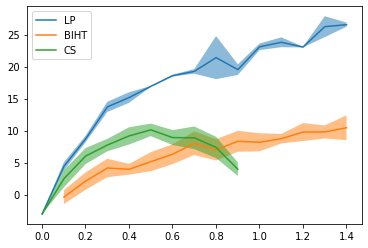

In [34]:
plt.plot(np.array(m_n) / n, avg_snr, label="LP")
plt.fill_between(
    np.array(m_n) / n,
    np.array(avg_snr) + np.array(std_snr),
    np.array(avg_snr) - np.array(std_snr),
    alpha=0.5,
)
plt.plot(np.array(m_n) / n, avg_snr_biht, label="BIHT")
plt.fill_between(
    np.array(m_n) / n,
    np.array(avg_snr_biht) + np.array(std_snr_biht),
    np.array(avg_snr_biht) - np.array(std_snr_biht),
    alpha=0.5,
)
l = len(avg_snr_cs)
plt.plot(np.array(m_n[:l]) / n, avg_snr_cs, label="CS")
plt.fill_between(
    np.array(m_n[:l]) / n,
    np.array(avg_snr_cs) + np.array(std_snr_cs),
    np.array(avg_snr_cs) - np.array(std_snr_cs),
    alpha=0.5,
)
plt.legend()
plt.savefig("figures/summary_snr.png", dpi=800)

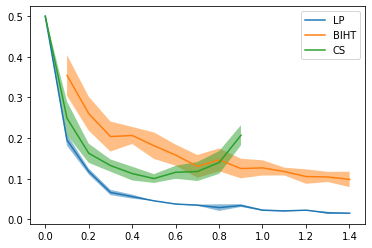

In [35]:
plt.plot(np.array(m_n) / n, avg_ang, label="LP")
plt.fill_between(
    np.array(m_n) / n,
    np.array(avg_ang) + np.array(std_ang),
    np.array(avg_ang) - np.array(std_ang),
    alpha=0.5,
)
plt.plot(np.array(m_n) / n, avg_ang_biht, label="BIHT")
plt.fill_between(
    np.array(m_n) / n,
    np.array(avg_ang_biht) + np.array(std_ang_biht),
    np.array(avg_ang_biht) - np.array(std_ang_biht),
    alpha=0.5,
)
plt.plot(np.array(m_n[:l]) / n, avg_ang_cs, label="CS")
plt.fill_between(
    np.array(m_n[:l]) / n,
    np.array(avg_ang_cs) + np.array(std_ang_cs),
    np.array(avg_ang_cs) - np.array(std_ang_cs),
    alpha=0.5,
)
plt.legend()
plt.savefig("figures/summary_angular.png", dpi=800)